# Bagging

* Consider the *regression problem*. 
* Suppose we fit a model to our training data $Z = {(x_1, y_1), (x_2, y_2), . . . , (x_N , y_N )}$, obtaining the prediction $\hat{f}(x)$ at input $x$

* Bootstrap aggregation or bagging averages this prediction over a collection of bootstrap samples, thereby reducing its variance

* For each bootstrap sample $Z^{∗b}, b = 1, 2, . . . , B$, we fit our model, giving prediction $\hat{f}^{∗b}$

$$ {f_{\text{bag}}}(x) = \frac{1}{B} \sum_{b = 1}^{B} \hat{f^{*b}}(x)$$


Denote by $\hat{P}$ the empirical distribution putting equal probability $1/N$ on each of the data points $(x_i, y_i)$

In fact the `true` bagging estimate is defined by $E_P[\hat{f}^{∗}(x)]$, where $Z∗ = {(x^{∗}_1, y^{∗}_1), (x^{∗}_2, y^{∗}_2), . . . , (x^{∗}_N , y^{∗}_N )}$ and each $(x_i^{*} , y_i^{∗}) ∼ \hat{P}$. 

Expression is a Monte Carlo estimate of the true bagging estimate, approaching it as $B → ∞$

For Regression tree where $\hat{f}(x)$ denotes the tree’s prediction at input vector $x$ 

The bagged estimate is the average prediction at $x$ from these $B$ trees

In [103]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import  numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection

In [96]:
# Data Simulation
x_sample = np.random.randn(1_000)
f = 9*np.sin(x_sample)
y_sample = f + np.random.randn(1_000)
data_sample = pd.DataFrame(dict(X = x_sample, y = y_sample))
X, y = data_sample.X, data_sample.y

# split data
data_train, data_test = model_selection.train_test_split(data_sample, random_state=123, test_size=0.25)

# fitting a model tree for each bag 
trees = []
for _ in range(10):
    bag = data_sample.sample(n = data_train.shape[0], replace=True)
    tree = DecisionTreeRegressor() 
    trees.append(tree.fit(bag[['X']], bag.y))

# Predicts using the tree model and reshape in order to concatenate for data test
trees_predicts = [np.reshape(tree.predict(data_test[['X']]), (-1, 1)) for tree in trees]

# compute the mean of the prediction
predict_bagging = np.hstack(trees_predicts).mean(axis=1)

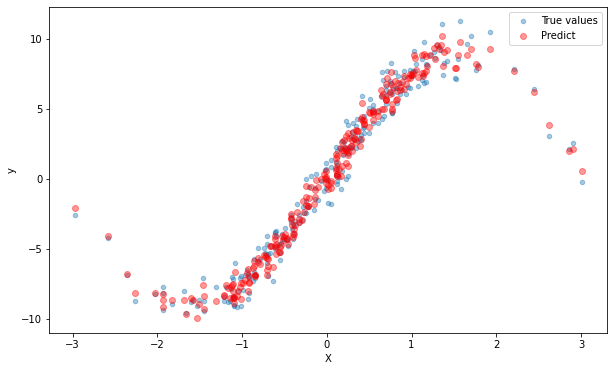

In [102]:
fig, ax= plt.subplots(figsize = (10, 6))

data_test.plot(kind = 'scatter', x = 'X', y = 'y', alpha = 0.4, ax = ax, label = 'True values')
ax.scatter(data_test.X, predict_bagging, alpha=0.4, color = 'r', label = 'Predict')
ax.legend(); plt.show()

Now suppose our tree produces a classifier $\hat{G}(x)$ for a $K$-class response. 

Here it is useful to consider an underlying indicator-vector function $\hat{f}(x)$, with value a single one and $K − 1$ zeroes, such that $\hat{G}(x) = \argmax_k \hat{f}(x)$. 

Then the bagged estimate $\hat{f}_{\text{bag}}(x)$ is a $K$-vector $[p_1(x), p_2(x), . . . , p_K(x)]$, with $p_k(x)$ equal to the proportion of trees predicting class $k$ at x. 

The bagged classifier selects the class with the most “votes” from the B trees, $\hat{G}_{\text{bag}}(x) = \argmax_k \hat{f}_{\text{bag}}(x)$

In [132]:
# Load the data
data_crime = pd.read_stata(r'data_dta/CRIME1.dta')

# Generate the variable arr86, where a person is labeled equal to 0, if he has not committed a crime in 1986
# otherwise 1.
data_crime['arr86'] = data_crime.narr86.where(data_crime.narr86==0, 1)

# Selecting the features and target
features= ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
target = 'arr86'

# split data
data_crime_train, data_crime_test = model_selection.train_test_split(data_crime, random_state=123, test_size=0.25)

# fitting a model tree for each bag 
trees = []
predicts_init = np.zeros(shape=(data_crime_test.shape[0], 2))
B = 10
for _ in range(B):
    bag = data_crime_train.sample(n = data_crime_train.shape[0], replace=True)
    tree = DecisionTreeClassifier() 
    trees.append(tree.fit(bag[features], bag[target]))
    predicts = np.where(tree.predict_proba(data_crime_test[features])<0.5, 0, 1)
    predicts_init += predicts

In [133]:
#  Recall, predicts are like [0.01, 2.1]
# argmax choose the index thta have the max value between the two,
# The index coincide match with the class
y_predicts = np.argmax(predicts_init/B, axis=1) 

In [141]:
np.mean(y_predicts == data_crime_test[target].values)

0.7287390029325513

# Boosting and Additive Trees



### AdaBoost.M1

For the explanation is used a classification model, but we can apply the same idea for regression model.

So we start here:

* The output variable is coded as $Y ∈ \{−1, 1\}$

* Given a vector of predictor variables $X$, a classifier $G(X)$ produces a prediction taking one of the two values $\{−1, 1\}$. 

* The error rate on *training sample* is computed:
$$\bar{\text{err}} = \frac{1}{N} \sum_{i=1}^{N} I(y_i \ne G(x_i) )$$

* And the expected error for the future $E[I(y_i \ne G(x_i) )]$

* Boosting uses `weak classifier` which is defined as as classifier whose error rate is  slightly better than random guessing.

* Boosting sequentially applies the weak classification algorithm to repeatedly modified versions of the data (weighted data).

  Recall that this data is get using *boostrap method* (resampling the original sample with replacement)
  
* So, it produces a sequence of weak classifiers $G_m(x), m = 1, 2, . . . , M.$ 
$$G(x) = \text{sign}[\sum_{m=1}^{M} \alpha_m G_m (x)]$$

* $\alpha_m$ and $G_m$ is computed by boosting algorithm. And $M$ is the amount of resampling.

  *Boosting method*

  * 1. Initialize the weights $w_i = 1/N$, $i = 1, 2, ..., N$
  * 2. For $m = 1$ to $M$:
  
    * Fit the classifier $G_m(x)$ to the training data using the weights $w_i$

    * Compute $\bar{\text{err}} = \frac{\sum_{i=1}^{N} w_i I(y_i \ne G(x_i) )}{\sum_{i=1}^{N} w_i} $
    
    * Compute $ α_m = \log((1 − \text{err}_m)/\text{err}_m)$
    
    * Set $w_i \leftarrow w_i.\exp[\alpha_m I(y_i \ne G(x_i) )] $
    
  
  * 3. The output: $G(x) = \text{sign}[\sum_{m=1}^{M} \alpha_m G_m (x)]$


* Their effect is to give higher influence to the more accurate classifiers in the sequence. The relationship between $\text{err}_m$ and $α_m$ show when $\text{err}_m$ decrece, then, $α_m$ increase.so a model with lower error has more weight in the final output.

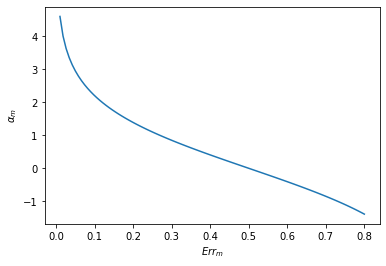

In [4]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

err_m = np.linspace(0.01, 0.8, 100)
alpha = np.log((1 - err_m)/err_m)

ax.plot(err_m, alpha)
ax.set(xlabel = r'$Err_m$', ylabel = r'$\alpha_m$')
plt.show()

* The data modifications at each boosting step consist of applying weights $w_1, w_2, . . . , w_N$ to each of the training observations $(x_i, y_i), i = 1, 2, . . . , N.$ Initially all of the weights are set to $w_i = 1/N$.

* For each successive iteration $m = 2, 3, . . . , M$ the observation weights are individually modified and the classification algorithm is reapplied to the weighted observations

* At step $m$, *those observations that were misclassified* by the classifier $G_{m−1}(x)$ induced at the previous step have their *weights increased*, whereas the *weights are decreased* for *those that were classified correctly*. 

* Thus as iterations proceed, `observations that are difficult to classify correctly receive ever-increasing influence`. Each successive classifier is thereby forced to concentrate on those training observations that are missed by previous ones in the sequence.

> Most of this work has centered on using classification trees as the “base learner” like a “stump”: a two terminal node classification tree. 

#### Boosting Fits an Additive Model

* Boosting is a way of fitting an additive expansion in a set of elementary “basis” functions.

* Basis function expansions take the form 

$$f(x) = \sum_{m=1}^{M} β_m b(x; γ_m)$$

* where $β_m, m = 1, 2, . . . , M$ are the expansion coefficients, and $b(x; γ)∈ \R$ are usually simple functions of the multivariate argument $x$, characterized by a set of parameters $γ$

* **Forward Stagewise Additive Modeling**:

  1. Initialize $f_0(x) = 0$.
  2. For $m = 1$ to $M$:
    
      (a) Compute
      $$(β_m, γ_m) = \arg \min_{\beta, γ} \sum_{i=1}^{N} L(y_i, f_{m- 1 }(x_i) + \beta b(x_i, γ )) $$
      
      (b) Set $ f_m(x) = f_{m−1}(x) + β_mb(x; γ_m)$

  Here the error $\beta b(x_i, γ )$ is fitted to reduce the error the early model $f_{m- 1 }(x_i)$

  If we use Exponential Loss Function *AdaBoost.M1* is equivalent to *forward stagewise additive* modeling. $L(y, f(x)) = \exp(−y f(x)).$

  We choice the *exponential loss function* The principal attraction of exponential loss in the context of additive modeling is computational; it leads to the simple modular reweighting AdaBoost algorithm. 
  
  $$f^{∗}(x) = \argmin f(x) E_{Y |x}(e^{− Y f(x)}) = \frac{1}{2}\log \frac{\text{Pr}(Y = 1| x)} {\text{Pr}(Y=−1|x)
  }$$

* Data sets are often very large in terms of number of observations and number of variables measured on each of them. Thus, computational considerations play an important role. 

* The inputs tend to be mixtures of quantitative, binary, and categorical variables. Also they include `NaN`. The scales also are different in the variables.

* The relevant variables that in actually are need to predict are small, but we don't know what are.

* The interpretation of the models are useful in order to know the relationship between the inputs variables.

> An `off-the-shelf` method is one that can be directly applied to the data without requiring a great deal of timeconsuming data preprocessing or careful tuning of the learning procedure.

* The decision tree is the method that is close to *off-the-shelf*.  They are relatively fast to construct and they produce interpretable models. They are invariant under (strictly monotone) transformations of the individual predictors and inmute to outliers. They are thereby resistant to the inclusion of many irrelevant predictor variables. The disadvantage is the accuracy, this is improved with the boosting, but we sacrify the speed and interpretability.

### Boosting Trees

The tree methods partition the space of all joint predictor variable values into disjoint regions $R_j, j = 1, 2, ..., J$, as represented by the terminal nodes of the tree.

A constant $γ_j$ is assigned to each such region and the predictive rule is

$$x ∈ R_j ⇒ f(x) = γ_j.$$

Thus a tree can be formally expressed as

$$T(x; Θ) = \sum_{1}^{J} γ_jI(x ∈ R_j)$$

with parameters $Θ = \{R_j, γ_j\}^J$

The parameters are found by minimizing the empirical risk (loss function)

$$ \hat{Θ} = \argmin_Θ \sum_{j=1}^{J} \sum_{x_i \in R_j} L(y_i, γ_j)$$

 It is useful to divide the optimization problem into two parts:

 * Finding $R_j$: here we change the criterion of optimization by ($N$ is the size of the data.)

$$ \hat{Θ} = \argmin_Θ \sum_{i=1}^{N} \tilde{L}(y_i, T(x_i, Θ)) $$


* Finding $γ_j$ given $R_j$: Given the $R_j$, estimating the $γ_j$ is typically trivial, and often $γ_j = \bar{y}_j$, the mean of the $y_i$ falling in region $R_j$ .


The boosted tree model is a sum of such trees

$$ f_M(x) = \sum_{m=1}^M  T(x; Θ_m)$$

At each step in the forward stagewise procedure one must solve

$$ \hat{Θ}_m = \arg \min_{\beta, γ} \sum_{i=1}^{N} L(y_i, f_{m- 1 }(x_i) + T(x_i, {Θ}_m )) $$


for the region set and constants $Θ_m = \{R_{j_m}, γ_{j_m}\}^J$

Given the regions $R_{j_m}$, finding the optimal constants $γ_{j_m}$ in each region is typically straightforward:



$$\hat{j}_m = \argmin γ_{j_m} \sum_{x_i ∈ R_{j_m}} L (y_i, f_{m−1}(x_i) + γ_{j_m})$$



Modal class in statistics refers to a class having the highest frequency
pag 372

### Regularization

Each iteration
usually reduces the training risk L(fM), so that for M large enough this risk
can be made arbitrarily small. However, fitting the training data too well
can lead to overfitting, which degrades the risk on future predictions. Thus,
there is an optimal number M∗ minimizing future risk that is application
dependent. A convenient way to estimate M∗ is to monitor prediction risk
as a function of M on a validation sample. The value of M that minimizes
this risk is taken to be an estimate of M∗

### Interpretation


#### Relative Importance of Predictor Variables


For a single decision tree T , Breiman et al. (1984) proposed

$$I^2_ℓ(T) = \sum_{t=1}^{J−1} \hat{ı}_t^2 I(v(t) = ℓ)$$

as a measure of relevance for each predictor variable Xℓ. The sum is over
the J − 1 internal nodes of the tree. At each such node t, one of the input
variables X
v(t) is used to partition the region associated with that node into
two subregions; within each a separate constant is fit to the response values.
The particular variable chosen is the one that gives maximal estimated
improvement ˆı2 t in squared error risk over that for a constant fit over the
entire region. The squared relative importance of variable Xℓ is the sum of
such squared improvements over all internal nodes for which it was chosen
as the splitting variable.


This importance measure is easily generalized to additive tree expansions
(10.28); it is simply averaged over the trees

$$ I^2_ℓ = \frac{1}{M} \sum_{m =1}^{M} I^2_ℓ(T_m)$$

More informacion: [Master Thesis](https://www.ifi.uzh.ch/dam/jcr:82fc9567-e690-40fa-baff-eb7a37aa00c0/MasterThesis.pdf)

In [1]:
from sklearn.ensemble import GradientBoostingClassifier 
import xgboost
from sklearn import model_selection, metrics
import pandas as pd
import shap

In [2]:
# Load the data
data_crime = pd.read_stata(r'data_dta/CRIME1.dta')

# Generate the variable arr86, where a person is labeled equal to 0, if 
# he or she has not committed a crime in 1986, otherwise 1.
data_crime['arr86'] = data_crime.narr86.where(data_crime.narr86==0, 1)

# Selecting the features and target
features= ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
target = 'arr86'
X, y = data_crime[features], data_crime[target]

# Split data
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, random_state=123, test_size=0.25)

In [171]:
GBC = GradientBoostingClassifier(n_estimators=200, max_depth=10)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=200)

In [172]:
def checkdata(X_train:pd.DataFrame, X_test:pd.DataFrame):
    """
    This function has the purpose Check the range of the values
    of the features
    X_train:`pd.DataFrame`
    X_test:`pd.DataFrame`
    """
    
    def data_range(X):
        return X.agg(['max', 'min']).T
    
    range_train, range_test = data_range(X_train), data_range(X_test)
    range_train , range_test = range_train.add_prefix('Train_') , range_test.add_prefix('Test_')
    check_max = range_train['Train_max']>=range_test['Test_max']
    check_max.name = 'MAX'
    check_min = range_train['Train_min']<= range_test['Test_min']
    check_min.name = 'MIN'

    if check_max.all() & check_min.all():
        print('All Right')
    else:
        dg = ~ pd.concat([check_max, check_min], axis=1)  
        return dg.applymap(lambda x: 'Check Feature' if x else 'All Right')

checkdata(X_train, X_test)

All Right


In [69]:
metrics.roc_auc_score(y_test, GBC.predict(X_test))

0.5404045897003643

In [173]:
print(GBC.feature_importances_)
print(X_train.columns)

[0.39756494 0.09919987 0.06498023 0.18050772 0.25774723]
Index(['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86'], dtype='object')


In [181]:
model_xgb = xgboost.XGBClassifier(n_estimators=200, max_depth=10, use_label_encoder=False, objective='binary:logistic')
model_xgb.fit(X_train, y_train)

[21:01:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [182]:
metrics.roc_auc_score(y_train, model_xgb.predict(X_train))

0.5990692107049702

In [183]:
metrics.roc_auc_score(y_test, model_xgb.predict(X_test))

0.5373864810484529

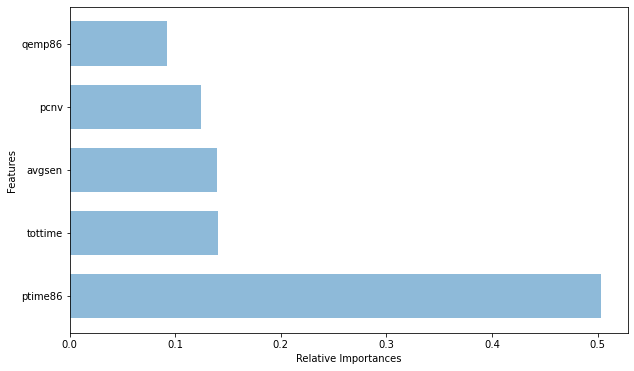

In [332]:
def plot_importances(model, columns):
    
    feat_serie = pd.Series(model.feature_importances_, columns)
    feat_serie.sort_values(ascending=False, inplace=True)
    features, importances = feat_serie.index, feat_serie.values

    _, ax = plt.subplots(figsize = (10, 6))
    ax.barh(features, importances, height=0.7, alpha = 0.5)
    ax.set(xlabel = 'Relative Importances', ylabel = 'Features')
    

    return ax

plot_importances(model_xgb, features); plt.show()

# Random Forest

Random forests (Breiman, 2001) is a substantial modification of bagging that builds a large collection of *de-correlated trees*, and then averages them.
On many problems the performance of random forests is very similar to boosting, and they are simpler to train and tune.

* The essential idea in bagging is to average many noisy but approximately unbiased models. The average reduce the variance. 

* Trees are ideal candidates for bagging, since they can capture complex interaction structures in the data, and if grown sufficiently deep, have relatively low bias. 

* Moreover, since each tree generated in bagging is identically distributed $(i.d.)$, the expectation of an average of $B$ such trees is the same as the expectation of any one of them. $E[\bar{X}] = E[X] = \mu $

* This means the bias of bagged trees is the same as that of the individual (bootstrap) trees, and the only hope of improvement is through variance reduction. 

* An average of $B$ i.i.d. rvs, each with variance $σ^2$, has variance $\frac{1}{B}σ^2$. 

* If the variables are simply i.d. (identically distributed, but not necessarily independent) with positive pairwise correlation $ρ$, the variance
of the average is 

$$ρ\sigma^2 + \frac{(1 - ρ)}{B}\sigma^2$$

* Supposing all $\text{Var}$ and pairwise $\text{Cov}$ is the same for all rvs i.d.

* As $B$ increases, the second term disappears, but the first remains, and hence the size of the correlation of pairs of bagged trees limits the benefits
of averaging

* Random forests improve the variance reduction of bagging when reducing the correlation between the trees, without increasing the variance too much. 

* This is **achieved** in the tree-growing process **through random selection of the input variables**.

* Specifically, when growing a tree on a `bootstrapped dataset`:

<center>


**Before each split, select m ≤ p of the input variables at random as candidates for splitting.**


</center>

* Typically values for $m$ are $\sqrt{p}$ or even as low as $1$.
* Recall, regression and classification trees partition the space of all joint predictor variable values into disjoint regions $R_j, j = 1, 2, . . . , J$, as represented by the terminal nodes of the tree.

* A constant $γ_j$ is assigned to each such region and the predictive rule is

$$x ∈ R_j ⇒ f(x) = γ_j$$

* Thus a tree can be formally expressed as

$$ T(x; Θ) = \sum_{j=1}^{J} γ_j I(x ∈ R_j) $$ 

* with parameters $Θ = \{R_j, γ_j\}^J$ . $J$ is usually treated as a meta-parameter.
* After B such trees $B$ are grown,  the random forest (regression) predictor is:

$$\hat{f}_{\text{rf}}^{B}(x) = \frac{1}{B} \sum_{b = 1}^{B} T(x; Θ)$$

* $Θ_b$ characterizes the bth random forest tree in terms of split variables, cutpoints at each node, and terminal-node values.

* Intuitively, reducing $m$ will reduce the correlation between any pair of trees in the ensemble, and hence reduce the variance of the average.

* In generally, gradient boosting is better than random forest

* `Out the bag` sample is the dataset that were not used to fit the $B$ models, almost alway is 1/3 of the original data.

* This data are used to evaluate the predictions of random forest model $\hat{f}_{\text{rf}}^{B}(x)$.

* It pass this dataset on the fitten model by bostraping dataset and compute **Out of the Bag error** `OOBE`

* Then, refit the models using differents $\text{m} + 1$  columns (features) instead $\text{m}$ and compare the `OOBE` of the models 

* The process is iterative, and the best model is choosen



In [333]:
from sklearn.ensemble import RandomForestClassifier # RandomForestRegressor
import pandas as pd
import numpy as np

In [334]:
# Load the data
data_crimen = pd.read_stata(r'data_dta/CRIME1.dta')

# Generate the variable arr86, where a person is labeled equal to 0, if he has not committed a crime in 1986
# otherwise 1.
data_crimen['arr86'] = data_crimen.narr86.where(data_crimen.narr86==0, 1)

# Selecting the features and target
features= ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
target = 'arr86'

X, y = data_crimen[features], data_crimen[target]
# split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=123, test_size=0.25)

In [335]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, verbose=True)
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


RandomForestClassifier(n_estimators=200, oob_score=True, verbose=True)

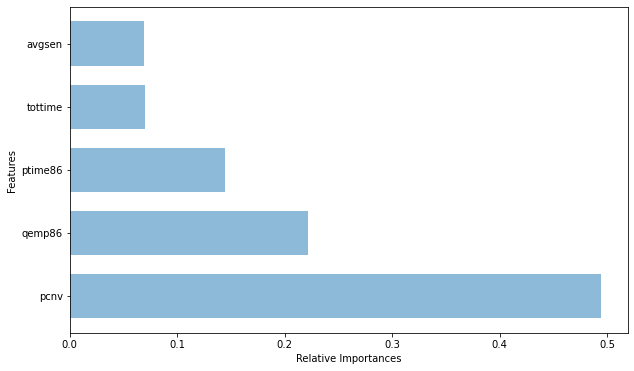

In [337]:
plot_importances(rf, features); plt.show()

In [57]:
metrics.roc_auc_score(y_test, rf.predict(X_test))

0.5404045897003643

In [175]:
rf.oob_score_

0.7205090553108174

In [174]:
rf.oob_decision_function_

array([[0.93878915, 0.06121085],
       [0.76907574, 0.23092426],
       [0.9125167 , 0.0874833 ],
       ...,
       [0.74886688, 0.25113312],
       [0.71772075, 0.28227925],
       [0.69548384, 0.30451616]])

In [172]:
rf.score(X_train, y_train)

0.7689672050905532

# References

  1. Trevor Hastie, Robert Tibshirani, Jerome Friedman - The Elements of Statistical Learning Data Mining, Inference, and Prediction

  2. Robert V. Hogg -  Introduction to Mathematical Statistics

  3. [StatQuest with Josh Starmer -> YouTube](https://www.youtube.com/watch?v=sQ870aTKqiM)

  4. [AdaBoost, Clearly Explained](https://www.youtube.com/watch?v=LsK-xG1cLYA)
